# Setup

In [1]:
%matplotlib inline

In [2]:
# Library imports
from fastai.vision.all import *
from nbdev.showdoc import *
from pathlib import *
# from zipfile import ZipFile

set_seed(42) # for reproducible random numbers

In [3]:
# Change this to another device (0-7) if you run out of memory
# Goto Kernel->Restart&Clear Output after changing the device
torch.cuda.set_device(4)

In [4]:
# Batch size: https://docs.paperspace.com/machine-learning/wiki/epoch
# Typically 32 works fine, feel free to experiment with it
# If you run out of memory, try to lower the number
bs = 32

# Get Data

In [5]:
path = 'competition_group2/group2_dataset'

In [6]:

# with ZipFile('competition_group2.zip', 'r') as archive:
#     archive.extractall('/home/ele_group_2/ml/')

In [7]:
fns=get_image_files(path)
fns

(#901) [Path('competition_group2/group2_dataset/091.jpg'),Path('competition_group2/group2_dataset/753.jpg'),Path('competition_group2/group2_dataset/495.jpg'),Path('competition_group2/group2_dataset/284.jpg'),Path('competition_group2/group2_dataset/463.jpg'),Path('competition_group2/group2_dataset/468.jpg'),Path('competition_group2/group2_dataset/083.jpg'),Path('competition_group2/group2_dataset/489.jpg'),Path('competition_group2/group2_dataset/089.jpg'),Path('competition_group2/group2_dataset/748.jpg')...]

In [8]:
df = pd.read_csv('competition_group2/labels_group2.csv',  dtype=str , sep=';')

In [9]:
df.head()

,id,label
0,000,common_wheat
1,001,common_chickweed
2,002,common_chickweed
3,003,common_chickweed
4,004,common_chickweed


# Data Loader

In [10]:
# plants = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                    get_items=get_image_files,
#                    splitter=RandomSplitter(valid_pct=0.2,seed=42),
#                    get_x=ColReader(0, path, suff=".jpg"),
#                    get_y=ColReader(1, label_delim=' '),
#                    item_tfms = Resize(460),
#                    batch_tfms=aug_transforms(size=224))

In [11]:
# dls=plants.dataloaders(path, bs=32)

In [12]:
dls = ImageDataLoaders.from_df(df, path,suff='.jpg',item_tfms=Resize(460),batch_tfms=aug_transforms(size=224),valid_pct=(0.2),seed=42,bs=128)

/home/ele_group_2/miniconda3/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


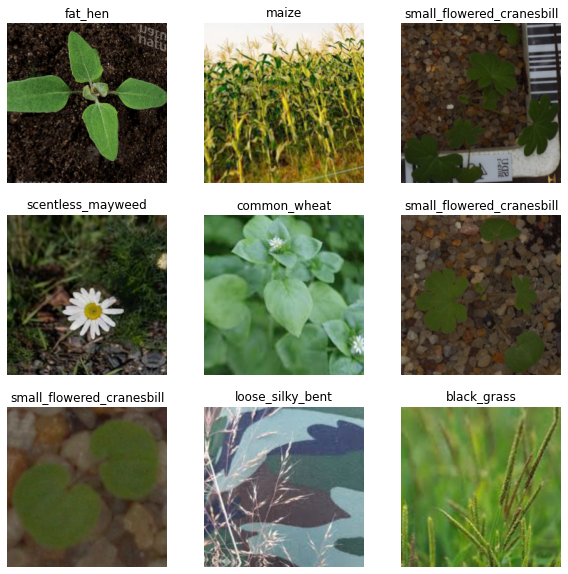

In [13]:
dls.show_batch(max_n=9, figsize=(10,10))

# Model Building

In [14]:
learner = cnn_learner(dls, resnet50, metrics=[accuracy, error_rate])

/home/ele_group_2/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Learning

In [28]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.435851,0.906893,0.788889,0.211111,00:05
1,0.484713,2.507185,0.605556,0.394444,00:05
2,0.525774,3.152647,0.616667,0.383333,00:05
3,0.492710,1.402121,0.722222,0.277778,00:05
4,0.432605,0.927018,0.783333,0.216667,00:05


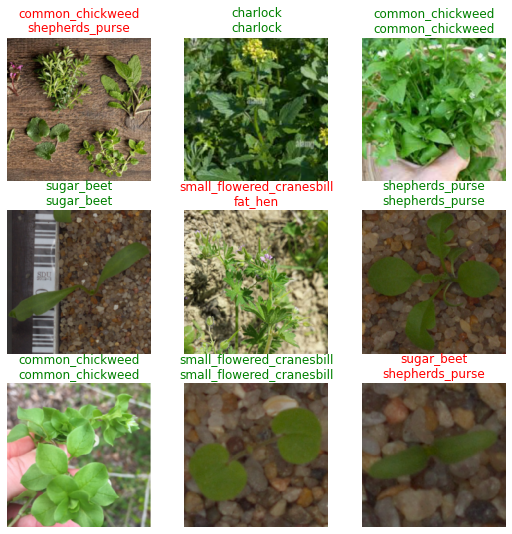

In [16]:
learner.show_results()

/home/ele_group_2/miniconda3/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0005754399462603033)

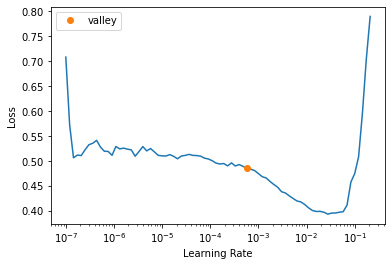

In [17]:
learner.lr_find()

In [18]:
learner.fine_tune(2, 0.0003)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.564933,0.704849,0.783333,0.216667,00:05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.506962,0.695042,0.788889,0.211111,00:06
1,0.498641,0.685529,0.794444,0.205556,00:05


In [19]:
print("Accuracy: ",1-float(learner.recorder.metrics[0].value))

Accuracy:  0.20555555820465088


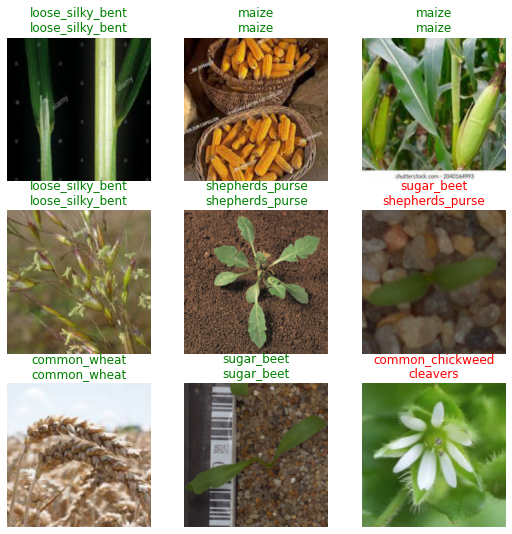

In [20]:
learner.show_results()

In [21]:
learner.save('tunde-aluko-weed-model-stage-1')

Path('competition_group2/group2_dataset/models/tunde-aluko-weed-model-stage-1.pth')

# Some  Analysis

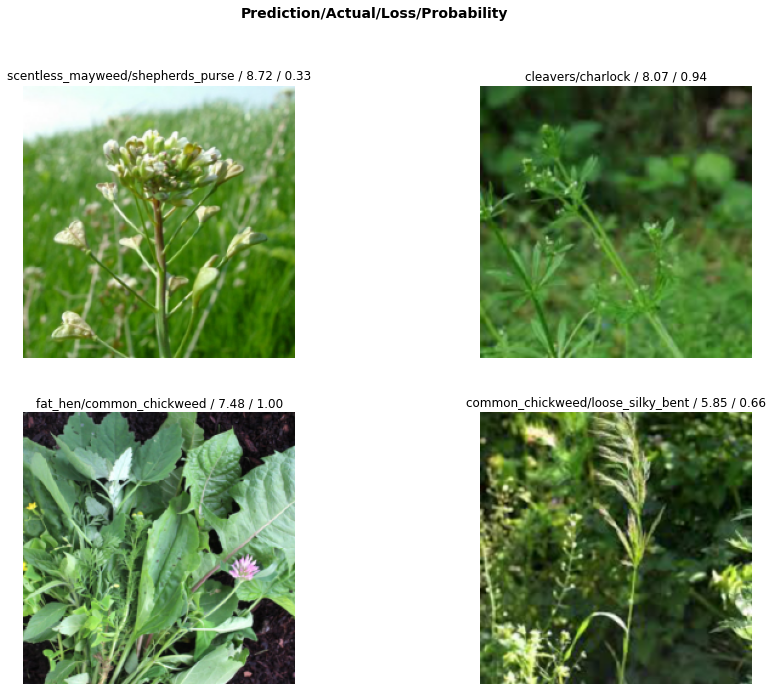

In [22]:
interpretation = ClassificationInterpretation.from_learner(learner)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(4, figsize=(15,11))

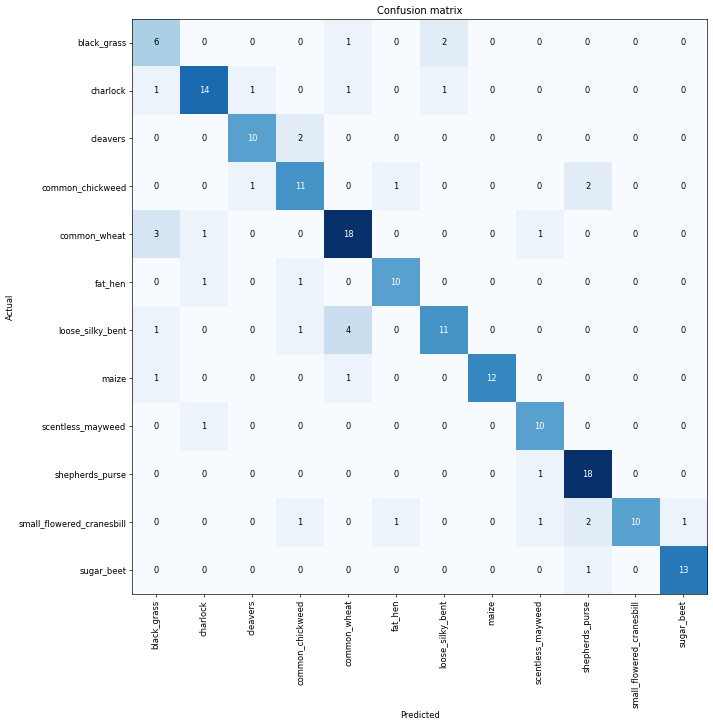

In [23]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
interpretation.most_confused(min_val=2)

[('loose_silky_bent', 'common_wheat', 4),
 ('common_wheat', 'black_grass', 3),
 ('black_grass', 'loose_silky_bent', 2),
 ('cleavers', 'common_chickweed', 2),
 ('common_chickweed', 'shepherds_purse', 2),
 ('small_flowered_cranesbill', 'shepherds_purse', 2)]

# Prediction

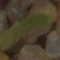

In [25]:
image_path = 'plant_seedlings_v2/common_wheat/7.png'
img=load_image(image_path)
img

In [26]:
label,_,probs = learner.predict(image_path)
print(label.split('/')[-1])
print(max(probs))

shepherds_purse
tensor(0.8756)


# Optimization